cardnumber	title	surname	firstname	dateofbirth	initials	othernames	relationship	streetnumber	streettype	address	address2	city	zipcode	country	phone	mobile	email	branchcode	categorycode	dateenrolled	dateexpiry	borrowernotes	userid	password	gonenoaddress	borrower_attribute_types


# A MODIFIER

* [ ] Ajouter dans le script les colonnes supprimées dans Excel
        > **liste des colonnes :** 	

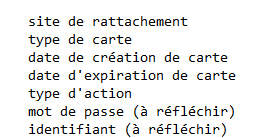

* [ ] Ajouter un paramètre `sheet_name`dans la classe ImportNoticesAdherents

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from kiblib.utils import import_notices_adherents #Objet python pour convertir le tableaue excel en fichier csv avec bon nom de colonnes

In [2]:
from kiblib.utils.db import DbConn

In [3]:
db_conn = DbConn().create_engine()

# LE SCRIPT FONCTIONNEL

In [4]:
#import pandas as pd
#import datetime as dt


class ImportNoticeAdherents:
    def __init__(self,data_adherents,format_file,sheet_name,):
        self.data_adherents = data_adherents
        self.format_file = format_file
        self.sheet_name = sheet_name
        
    def get_notice_adherents(self):
        self.data_adherents = pd.read_excel(f'../data_lucas/{self.data_adherents}.{self.format_file}',
                                            sheet_name='liste_adherents',
                                            dtype={'telephone fixe':str,'mobile':str})
        return(self.data_adherents)
    
    def update_columns(self):
        self.data_adherents = self.data_adherents.rename(columns={
            'numero de carte':'cardnumber',
            'civilite':'title',
            'nom de famille':'surname',
            'prenom':'firstname',
            'date de naissance':'dateofbirth',
            'autre nom':'othernames',
            'nom du garant':'contactname',
            'prenom du garant':'contactfirstname',
            'lieu naissance du garant':'altcontactsurname',
            'relation avec le garant':'relationship',
            'adresse':'address',
            'complement adresse':'address2',
            'ville':'city',
            'code postal':'zipcode',
            'telephone fixe':'phone',
            #'site de rattachement':'branchcode',
            #'type de carte':'categorycode',
            #'date de creation de carte':'dateenrolled',
            #'date expiration':'dateexpiry',
            #'identifiant':'userid',
            #'mot de passe':'password',
            #'parti sans laisser adresse':'gonenoadress',
            #'type action':'patron_attributes'       
                              })
        
        #Ajout des colonnes manquantes à Koha
        self.data_adherents['branchcode'] = 'MED'
        self.data_adherents['categorycode'] = 'BIBL'
        self.data_adherents['patron_attributes'] = 'ACTION:AM09'
        self.data_adherents['userid'] = self.data_adherents['cardnumber']
        self.data_adherents['password'] = pd.DatetimeIndex(self.data_adherents['dateofbirth']).date
        
        
        #On transforme les colonnes dont les valeurs doivent être en majuscule
        columns_to_uppercase = ['cardnumber','surname', 'address','city']
        self.data_adherents[columns_to_uppercase] = self.data_adherents[columns_to_uppercase].applymap(str.upper)
        return(self.data_adherents)

        
    def get_cartes2create(self):
        
        #On garde une liste des adhérents avec autorisation parentales non transmises
        adherents_rejetes = self.data_adherents[self.data_adherents['autorisation transmise ?']=='NON']
        
        query = """SELECT cardnumber AS 'cartes_existantes' FROM koha_prod.borrowers"""
        adherents = pd.read_sql(query,db_conn)
        adherents['cartes_existantes'] = adherents['cartes_existantes'].str.upper()

        #On filtre pour ne garder que les lignes avec autorisation parentale transmise
        self.data_adherents = self.data_adherents[self.data_adherents['autorisation transmise ?']=='OUI']
        
        #Suppression des lignes pour lesquelles adherents déjà inscrits
        self.data_adherents = self.data_adherents.merge(adherents,left_on='cardnumber',right_on='cartes_existantes',how='left')
        self.data_adherents['deja inscrit ?'] = np.where(self.data_adherents['cartes_existantes'].isna(),'NON','OUI')
        
        #On créer une variable qui contient les adherents deja inscrits
        adherents_deja_inscrits = self.data_adherents[self.data_adherents['deja inscrit ?']=='OUI']
        
        
        #On transforme le dataframe pour ne garder que les adherents pas encore inscrits
        self.data_adherents = self.data_adherents[self.data_adherents['deja inscrit ?']=='NON']
        
        timestamp = dt.datetime.today().strftime('%Y-%m-%d')
        
        with pd.ExcelWriter(f"../data_lucas/listes_adherents_visites_de_classe{timestamp}.xlsx") as writer:
            self.data_adherents.to_excel(writer,sheet_name="nouveaux_adherents",index=False)
            adherents_deja_inscrits.to_excel(writer,sheet_name="adherents_deja_inscrits",index=False)
            adherents_rejetes.to_excel(writer,sheet_name="autorisation manquante",index=False)
    
    def get_cartes2import(self):
        timestamp = dt.datetime.today().strftime('%Y-%m-%d')
        self.data_adherents = self.data_adherents.to_csv(f'../data_lucas/data_import_adherents_lot_du_{timestamp}.csv')
        

In [5]:
df = ImportNoticeAdherents(data_adherents='demande_inscription_classe_Dereumaux_camille_20231024',
                           sheet_name='liste_adherents',
                           format_file='xlsx')

In [6]:
df.get_notice_adherents()

/home/kibini/miniconda3/envs/kibini/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,autorisation transmise ?,numero de carte,civilite,nom de famille,prenom,date de naissance,autre nom,nom du garant,prenom du garant,lieu naissance du garant,relation avec le garant,adresse,complement adresse,ville,code postal,telephone fixe,mobile,email
0,OUI,x0002764948,Madame,KIMPE,Maëliianna,2018-06-30,NaN,KIMPE,Ophélie,Roubaix,Mère,6 cour Fournier,NaN,Roubaix,59100,NaN,0650804966,sebastienlaura.kimpe@gmail.com
1,OUI,X0002764931,Madame,CASSEZ,Lucianna,2018-08-06,NaN,BOIDOUX,Anaïs,Lille,Mère,2 allée Pierre Auguste Renoie,apt 4,Roubaix,59100,NaN,0662452811,leanoahlouka@hotmail.fr
2,OUI,x0002764924,Monsieur,DAOU,Ismaël,2018-02-14,NaN,DAOU,Hayate,Maroc,Mère,60 rue Louise Braille,NaN,Roubaix,59100,NaN,0643056238,hayate13@hotmail.fr
3,OUI,x0002764917,Monsieur,KHALFI,Adam,2018-12-15,NaN,Khalfi,Youssef,Maroc,Père,32 Allée Henri Matisse,NaN,Roubaix,59100,NaN,0612760247,zakariak@hotmail.fr
4,OUI,x0002764900,Monsieur,SAIDJ,Idris,2018-02-07,NaN,CRITON,Vanessa,Tourcoing,Mère,104 rue Rubens,apt2,Roubaix,59100,NaN,0753773253,critonvanessa2023@gmail.com
5,OUI,x0002764894,Monsieur,MAACHE,Sohaib,2018-02-28,NaN,MAACHE,Nordine,Roubaix,Père,114 rue Rubens,NaN,Roubaix,59100,NaN,0622693249,nordinem45@gmail.com
6,OUI,x0002764887,Madame,RAHAL,Soujoud,2018-07-22,NaN,BOURLER,Laurine,Roubaix,Mère,rue Jean Baptiste Chardin,Batiment C Appt 51,Roubaix,59100,NaN,0622198561,laurine.bourler@laposte.net
7,OUI,x0002764870,Madame,MAGHROUDI,Havet,2018-09-08,NaN,BENHADDOU,Sana,Tourcoing,Mère,7 rue Jean Baptiste Greuze,Batiment A Appt 21,Roubaix,59100,NaN,0774428029,sana2612benha@gmail.com
8,NON,x0002764863,Monsieur,IBSATENE,Nahil,NaT,NaN,NaN,NaN,NaN,NaN,32 rue GeorgesVerriest,NaN,Roubaix,59100,NaN,0637580994,NaN


In [7]:
df.update_columns()

,autorisation transmise ?,cardnumber,title,surname,firstname,dateofbirth,othernames,contactname,contactfirstname,altcontactsurname,...,city,zipcode,phone,mobile,email,branchcode,categorycode,patron_attributes,userid,password
0,OUI,X0002764948,Madame,KIMPE,Maëliianna,2018-06-30,NaN,KIMPE,Ophélie,Roubaix,...,ROUBAIX,59100,NaN,0650804966,sebastienlaura.kimpe@gmail.com,MED,BIBL,ACTION:AM09,x0002764948,2018-06-30
1,OUI,X0002764931,Madame,CASSEZ,Lucianna,2018-08-06,NaN,BOIDOUX,Anaïs,Lille,...,ROUBAIX,59100,NaN,0662452811,leanoahlouka@hotmail.fr,MED,BIBL,ACTION:AM09,X0002764931,2018-08-06
2,OUI,X0002764924,Monsieur,DAOU,Ismaël,2018-02-14,NaN,DAOU,Hayate,Maroc,...,ROUBAIX,59100,NaN,0643056238,hayate13@hotmail.fr,MED,BIBL,ACTION:AM09,x0002764924,2018-02-14
3,OUI,X0002764917,Monsieur,KHALFI,Adam,2018-12-15,NaN,Khalfi,Youssef,Maroc,...,ROUBAIX,59100,NaN,0612760247,zakariak@hotmail.fr,MED,BIBL,ACTION:AM09,x0002764917,2018-12-15
4,OUI,X0002764900,Monsieur,SAIDJ,Idris,2018-02-07,NaN,CRITON,Vanessa,Tourcoing,...,ROUBAIX,59100,NaN,0753773253,critonvanessa2023@gmail.com,MED,BIBL,ACTION:AM09,x0002764900,2018-02-07
5,OUI,X0002764894,Monsieur,MAACHE,Sohaib,2018-02-28,NaN,MAACHE,Nordine,Roubaix,...,ROUBAIX,59100,NaN,0622693249,nordinem45@gmail.com,MED,BIBL,ACTION:AM09,x0002764894,2018-02-28
6,OUI,X0002764887,Madame,RAHAL,Soujoud,2018-07-22,NaN,BOURLER,Laurine,Roubaix,...,ROUBAIX,59100,NaN,0622198561,laurine.bourler@laposte.net,MED,BIBL,ACTION:AM09,x0002764887,2018-07-22
7,OUI,X0002764870,Madame,MAGHROUDI,Havet,2018-09-08,NaN,BENHADDOU,Sana,Tourcoing,...,ROUBAIX,59100,NaN,0774428029,sana2612benha@gmail.com,MED,BIBL,ACTION:AM09,x0002764870,2018-09-08
8,NON,X0002764863,Monsieur,IBSATENE,Nahil,NaT,NaN,NaN,NaN,NaN,...,ROUBAIX,59100,NaN,0637580994,NaN,MED,BIBL,ACTION:AM09,x0002764863,NaT


In [8]:
df.get_cartes2create()

In [9]:
df.get_cartes2import()